# Pululagua Inversion Examples



In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [2]:
filename = "./data/pululagua/pulu_real_data.csv"

raw_df, grid = io.import_pululagua(filename)

grid.to_csv("data/pululagua/pulu_grid.csv", sep=" ", header=False, index=False)

display(raw_df.head())

,Sample,Easting,Northing,Altitude,Thickness,MassArea,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)",...,"[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",total,Md(phi),Sorting,SkG,radius
5,PL12,4105,1558,2358,16.5,165,0,0,888.3,"1,203.1",...,19.92,7.91,1.67,0.32,0.03,100,-1.67,2.68,-0.02,"4,390.72"
24,PL40,1032,-4703,2599,28,280,833.76,"1,492.62","1,744.88","1,159.76",...,10.37,3.52,0.85,0.18,0.01,100,-4.2,2.96,0.23,"4,814.9"
25,PL41,1018,-4731,2615,35,350,"1,481.98",564.95,"2,152.07","1,155.8",...,12.18,3.88,0.78,0.15,0.01,100,-4.31,2.73,0.09,"4,839.29"
4,PL11,5068,-1933,2738,17,170,0,0,524.55,"1,151.43",...,9.18,3.86,0.83,0.16,0.02,99.9999,-1.63,2.45,0.01,"5,424.12"
6,PL13,5463,3958,1934,14,140,0,0,286.61,850.53,...,30.46,14.48,3.34,0.66,0.04,100,-0.5,2.42,-0.2,"6,746.12"


## Preprossessing Steps

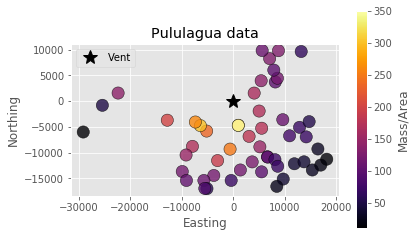

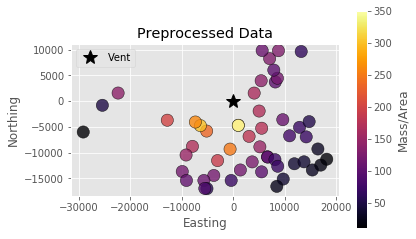

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Pululagua data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("pululagua/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("pululagua/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
t2_df, _, _, _ = io.read_tephra2("data/pululagua/pulu_out.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)","[-4,-3)","[-3,-2)",...,"[3,4)","[4,5)","[5,6)","[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",radius,Residual
0,4105,1558,0,159.345,0.0696127,0.363263,1.41018,4.11607,9.1122,15.4036,...,1.57705,0.0499285,0.000736347,7.41802e-06,5.50103e-08,2.55349e-10,9.14655e-13,2.54016e-15,"4,390.72",0.965727
1,1032,-4703,0,180.987,0.0579496,0.311125,1.23449,3.66294,8.20795,13.998,...,2.03938,0.0468926,0.000654533,6.53995e-06,4.84418e-08,2.24821e-10,8.05287e-13,2.23642e-15,"4,814.9",0.646382
2,1018,-4731,0,180.914,0.057607,0.309804,1.23085,3.65573,8.19777,13.9882,...,2.04084,0.0469223,0.000654824,6.54263e-06,4.84614e-08,2.24912e-10,8.05612e-13,2.23733e-15,"4,839.29",0.516897
3,5068,-1933,0,152.806,0.0548726,0.307602,1.26261,3.84461,8.7833,15.1939,...,1.58051,0.0521082,0.000768194,7.73605e-06,5.73652e-08,2.66277e-10,9.53798e-13,2.64887e-15,"5,424.12",0.898859
4,5463,3958,0,134.37,0.0400833,0.248334,1.10428,3.57868,8.57208,15.3609,...,1.36057,0.0571784,0.000869457,8.79166e-06,6.52298e-08,3.02807e-10,1.08466e-12,3.0123e-15,"6,746.12",0.959786


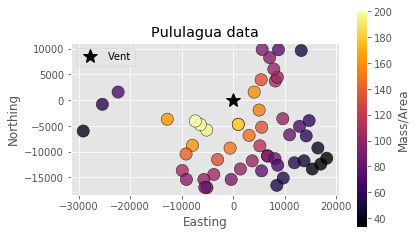

In [5]:
vis.plot_sample(t2_df, vent=(0,0), log=False, title="Pululagua data", cbar_label="Mass/Area")
plt.show()

In [6]:
config = io.read_tephra2_config("data/pululagua/pulu_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 19

config["MAX_GRAINSIZE"] = -8
config["MIN_GRAINSIZE"] = 11

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 0.1

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 2500.0,
 'PLUME_HEIGHT': 27000.0,
 'ALPHA': 1.1,
 'BETA': 1.1,
 'ERUPTION_MASS': 250000000000.0,
 'MAX_GRAINSIZE': -8,
 'MIN_GRAINSIZE': 11,
 'MEDIAN_GRAINSIZE': -0.2,
 'STD_GRAINSIZE': 2.0,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 92066.0,
 'FALL_TIME_THRESHOLD': 3600.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 19,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 0.1}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-7.5,"1,024","[-8,-7)",-8,9.93277e-05,-7
1,-6.5,"1,024","[-7,-6)",-7,0.00061611,-6
2,-5.5,"1,024","[-6,-5)",-6,0.00297627,-5
3,-4.5,"1,024","[-5,-4)",-5,0.0111973,-4
4,-3.5,"1,024","[-4,-3)",-4,0.0328079,-3
5,-2.5,"1,024","[-3,-2)",-3,0.0748637,-2
6,-1.5,"1,024","[-2,-1)",-2,0.133043,-1
7,-0.5,"1,024","[-1,0)",-1,0.184135,0
8,0.5,"1,233.5","[0,1)",0,0.198476,1
9,1.5,"1,443","[1,2)",1,0.166612,2


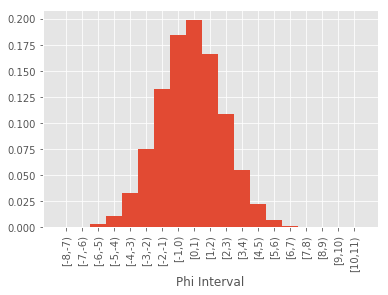

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xlabel("Phi Interval")
plt.show()

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(200)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 0,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values
display(forward_df.head())

Forward Sim time: 0.01562 seconds
Dataframe Merge time: 0.06250 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.03125 seconds
Total time: 0.10938 seconds


,Northing,Easting,"[-8,-7)","[-7,-6)","[-6,-5)","[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)",...,"[4,5)","[5,6)","[6,7)","[7,8)","[8,9)","[9,10)","[10,11)",MassArea,radius,Residual
0,1558,4105,0.0534419,0.279426,1.08655,3.17671,7.04596,11.9391,15.5367,15.3548,...,0.0497974,0.000630067,5.9401e-06,4.26281e-08,1.94426e-10,6.90354e-13,1.90886e-15,219.327,"4,390.72",1.32926
1,-4703,1032,0.0484693,0.260849,1.03713,3.08341,6.92412,11.8389,15.5072,15.3979,...,0.0504801,0.000638191,6.01531e-06,4.31662e-08,1.96879e-10,6.99064e-13,1.93294e-15,216.594,"4,814.9",0.773551
2,-4731,1018,0.0482061,0.259874,1.03462,3.079,6.91932,11.8371,15.5109,15.4059,...,0.0505384,0.000638962,6.02258e-06,4.32183e-08,1.97117e-10,6.99909e-13,1.93528e-15,216.333,"4,839.29",0.618094
3,-1933,5068,0.0423631,0.23815,0.979702,2.98916,6.84345,11.8682,15.7065,15.7127,...,0.0523607,0.000664193,6.26241e-06,4.49411e-08,2.04976e-10,7.27813e-13,2.01243e-15,208.039,"5,424.12",1.22376
4,3958,5463,0.0302957,0.188481,0.840588,2.73055,6.55544,11.7775,15.9957,16.3078,...,0.0567007,0.000722904,6.81802e-06,4.89296e-08,2.23168e-10,7.92409e-13,2.19104e-15,191.08,"6,746.12",1.36486


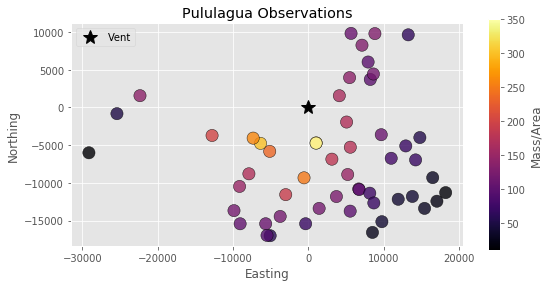

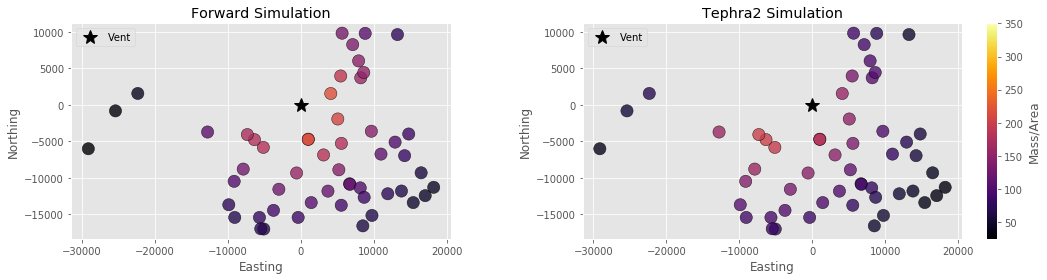

In [9]:
# fig, axs = plt.subplots(3,1, figsize=(
#         8,9), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# vis.plot_sample(obs_df, vent=(0,0), log=False, 
#             title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
# vis.plot_sample(forward_df, vent=(0,0), log=False, 
#             title="Forward Simulation", cbar_label="Mass/Area", ax=axs[1])
# # vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
# #             title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
# vis.plot_sample(t2_df, vent=(0,0), log=False, 
#             title="Tephra2 Simulation", cbar_label="Mass/Area", ax=axs[2])

# plt.tight_layout()
# plt.show()

# fig, axs = plt.subplots(1,2, figsize=(
#         12,3), facecolor='w', edgecolor='k')
# axs = axs.ravel()


# vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
#             title="Forward Simulation", 
#             cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
# # vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
# #             title="Tephra2 Simulation (Const. Wind)", 
# #             cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
# vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
#             title="Tephra2 Simulation", 
#             cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])




# plt.tight_layout()
# plt.show()


bounds = (25, 350)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

vis.plot_sample(obs_df, vent=(0,0), log=False, bounds=None,
            title="Pululagua Observations", cbar_label="Mass/Area", ax = ax)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(
        15.5,4), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=False, bounds=bounds, show_cbar=False,
            title="Forward Simulation", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(t2_df, vent=(0,0), log=False, bounds=bounds, show_cbar=True,
            title="Tephra2 Simulation", cbar_label="Mass/Area", ax=axs[1])

plt.tight_layout()
plt.show()




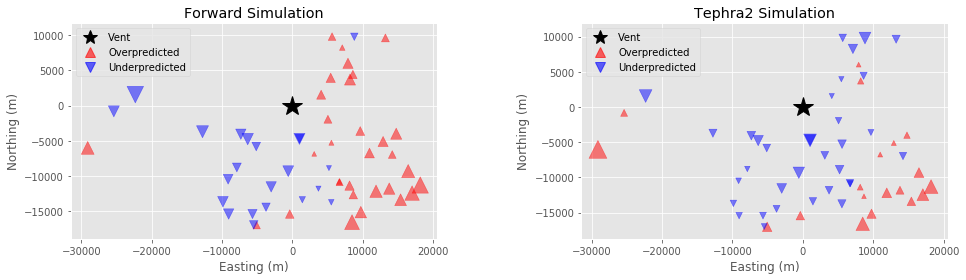

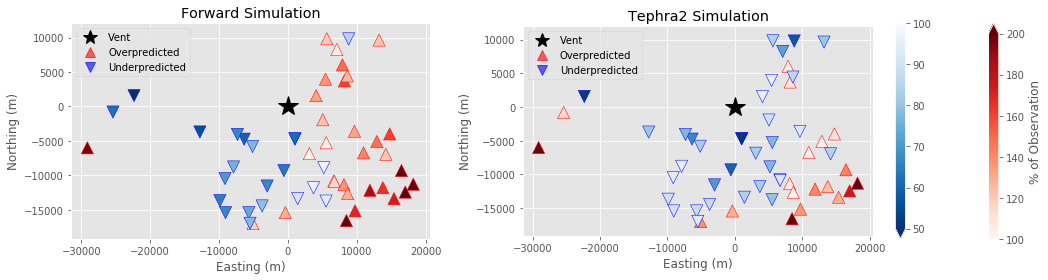

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(
        15.5,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation", 
            plot_type = "size", ax=axs[0])
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation", 
             plot_type = "size", ax=axs[1])


plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(
        15.5,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation", 
            plot_type = "cmap", ax=axs[0], show_cbar = False)
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation", 
             plot_type = "cmap", ax=axs[1], show_cbar = True)


plt.tight_layout()
plt.show()

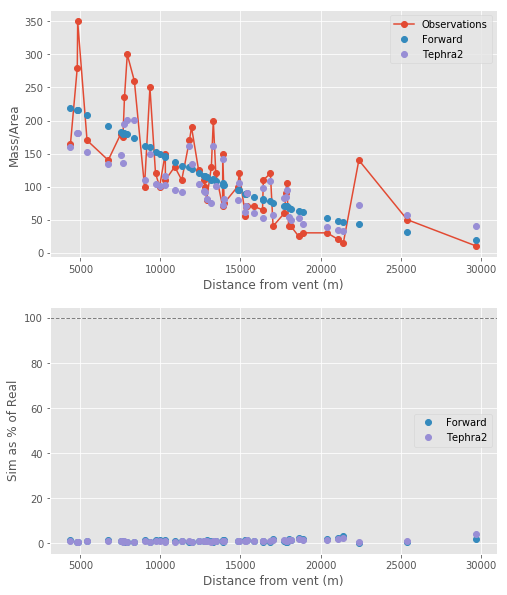

In [11]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C2o', label="Tephra2")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C2o', label="Tephra2")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========Forward Simulation========
a* = -1.63507	b* = -1.63507            	h1* = 3.23832
a = 1.19494	b = 1.19494	h1 = 38461.19337
Success: True, Optimization terminated successfully.
Iterations: 114
SSE: 850.8793110994606


,Height,Suspended Mass
0,"4,375",1.0655e+10
1,"6,250",1.20628e+10
2,"8,125",1.29032e+10
3,"10,000",1.34788e+10
4,"11,875",1.38923e+10
5,"13,750",1.41911e+10
6,"15,625",1.44008e+10
7,"17,500",1.45358e+10
8,"19,375",1.46041e+10
9,"21,250",1.46097e+10


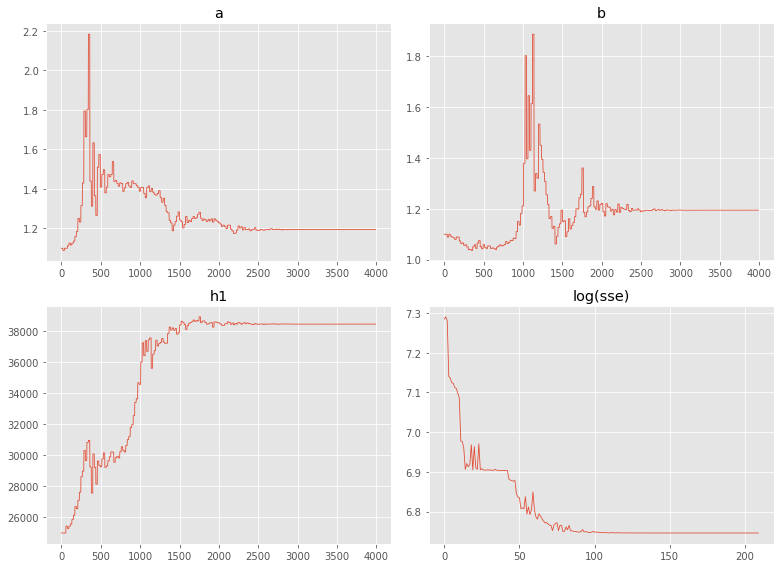

========T2 Simulation========
a* = -1.49640	b* = -1.94661            	h1* = 2.63946
a = 1.22394	b = 1.14276	h1 = 37243.59489
Success: True, Optimization terminated successfully.
Iterations: 121
SSE: 966.8670097073704


,Height,Suspended Mass
0,"4,375",1.00466e+10
1,"6,250",1.16356e+10
2,"8,125",1.26285e+10
3,"10,000",1.33415e+10
4,"11,875",1.3883e+10
5,"13,750",1.43039e+10
6,"15,625",1.46316e+10
7,"17,500",1.48817e+10
8,"19,375",1.50633e+10
9,"21,250",1.51808e+10


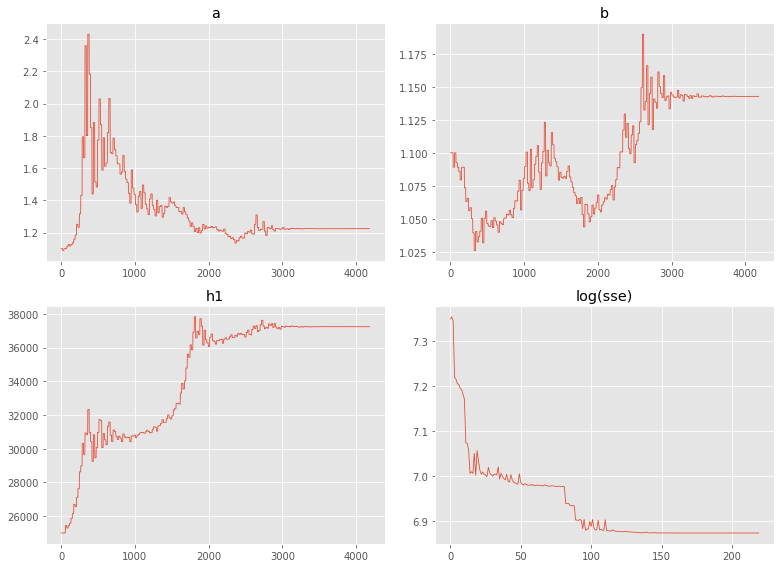

========Observation Data========
a* = -4.18647	b* = 2.03178            	h1* = 2.82924
a = 1.01520	b = 8.62765	h1 = 37706.09716
Success: True, Optimization terminated successfully.
Iterations: 153
SSE: 1238970318080.6387


,Height,Suspended Mass
0,"4,375",9.53004e+10
1,"6,250",6.19263e+10
2,"8,125",3.89911e+10
3,"10,000",2.37652e+10
4,"11,875",1.39729e+10
5,"13,750",7.8861e+09
6,"15,625",4.24518e+09
7,"17,500",2.16183e+09
8,"19,375",1.03038e+09
9,"21,250",4.53156e+08


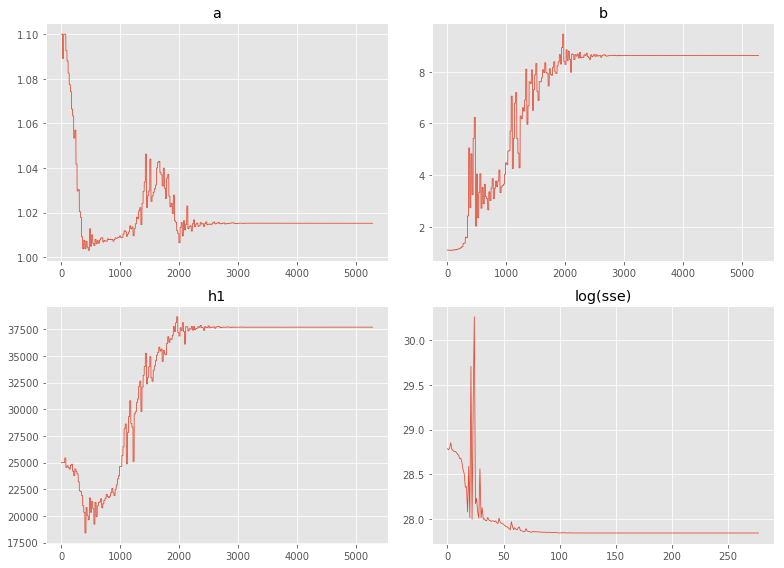

In [12]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 25000,
    "u": 1e-9,
    "v": 1e-9,
    "D": 1000,
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": False,
    "v": False,
    "D": False,
    "ftt": False,
    "M": False
}

H = 40000

wind_angle = np.radians(200)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
names = ["Forward Simulation", "T2 Simulation", "Observation Data"]
data_sets = [forward_df, t2_df, obs_df]
inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    print("========%s========"%name)
    out = gaussian_stack_plume_inversion(
        df, len(df), 20, 
        config["VENT_ELEVATION"], H, 0,
        phi_steps, config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, params, sol, sse, trace, coef_matrices, sse_trace = out
    
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    plt.tight_layout()
    plt.show()



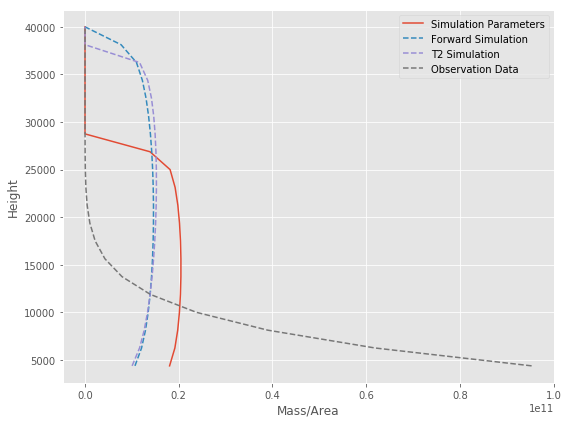

,Dataset,a,b,h1,u,v,D,ftt,M
0,Forward Simulation,1.19494,1.19494,"38,461.2",1e-09,1e-09,1000,"3,600",2.5e+11
1,T2 Simulation,1.22394,1.14276,"37,243.6",1e-09,1e-09,1000,"3,600",2.5e+11
2,Observation Data,1.0152,8.62765,"37,706.1",1e-09,1e-09,1000,"3,600",2.5e+11


In [13]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["Dataset"] = names
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

========Forward Simulation========


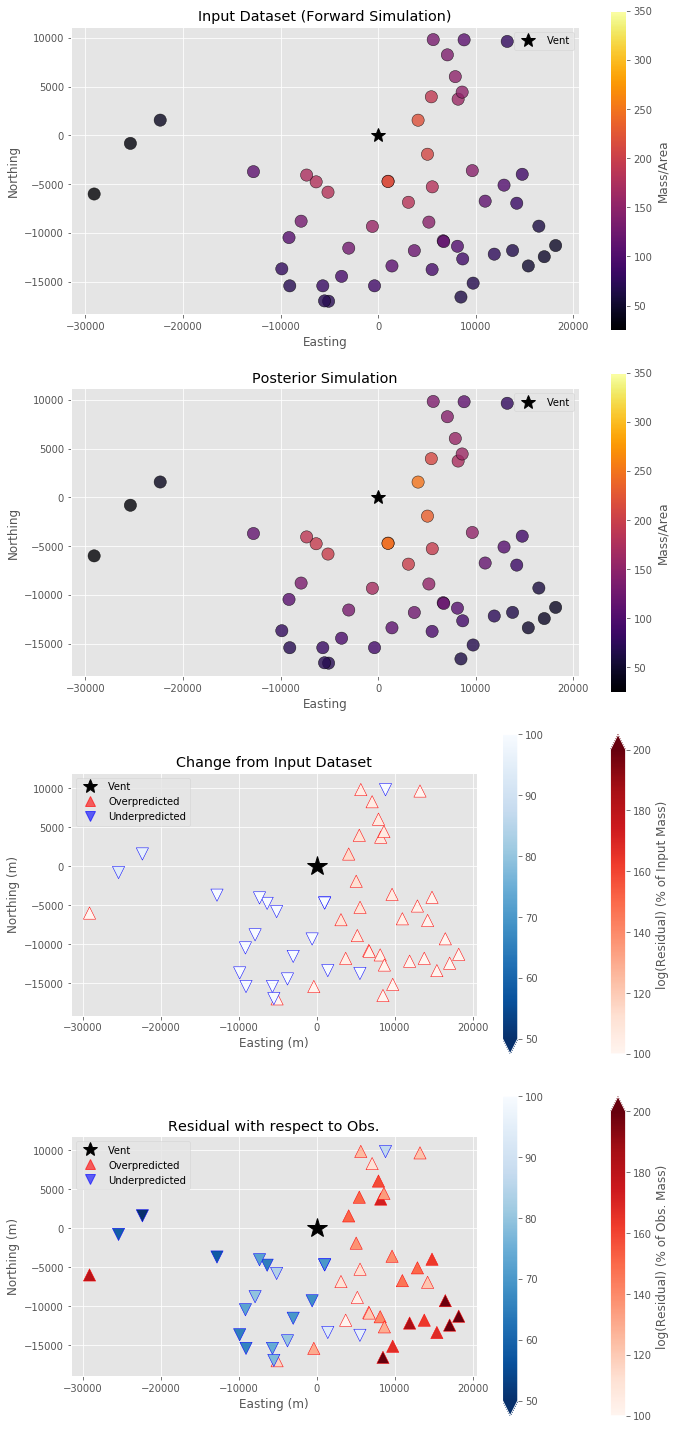

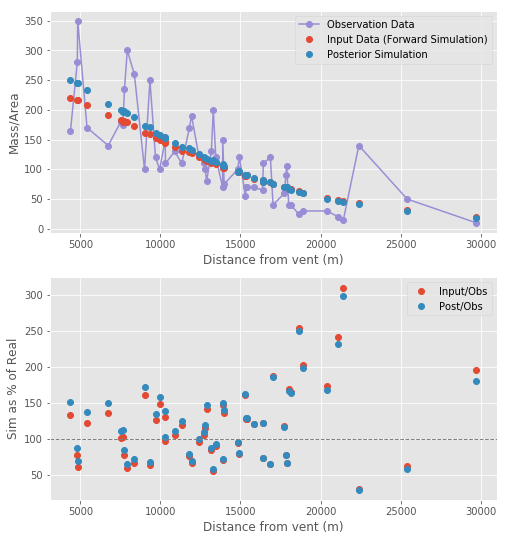

========T2 Simulation========


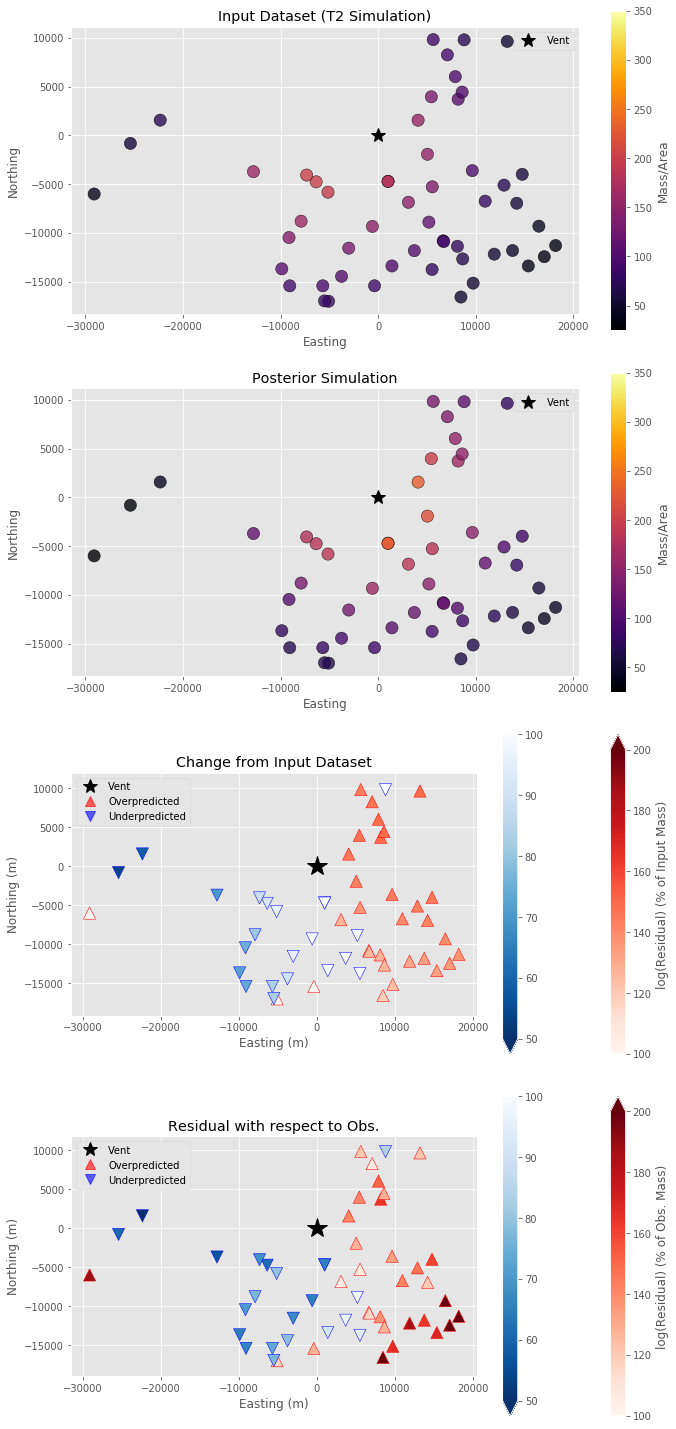

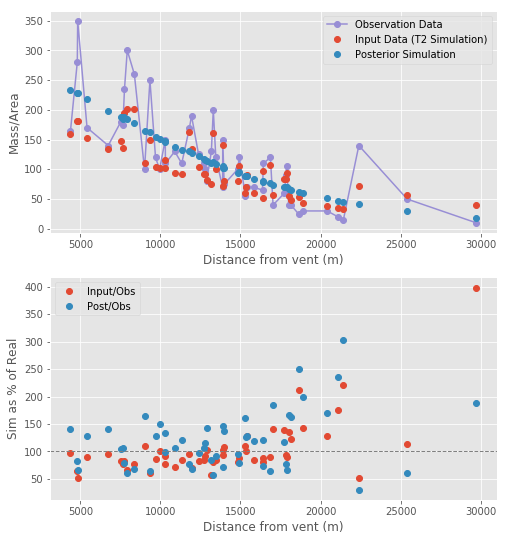

========Observation Data========


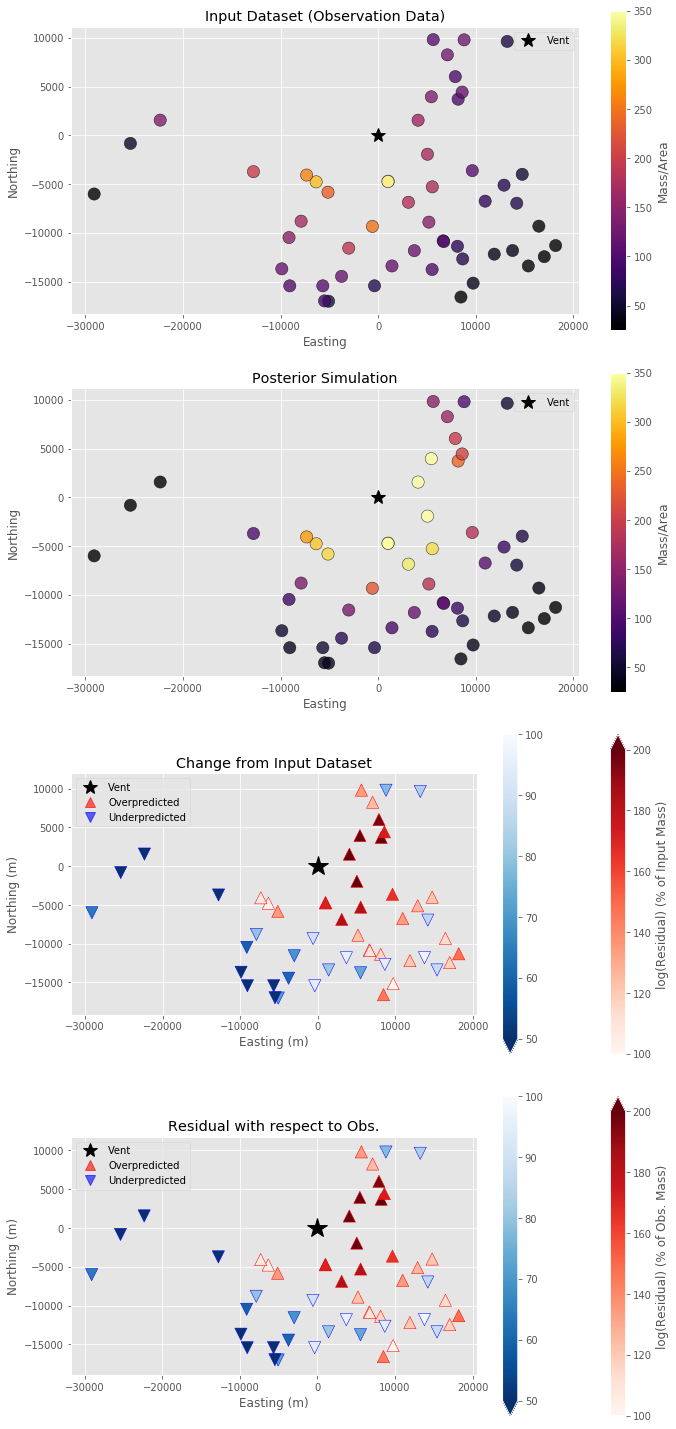

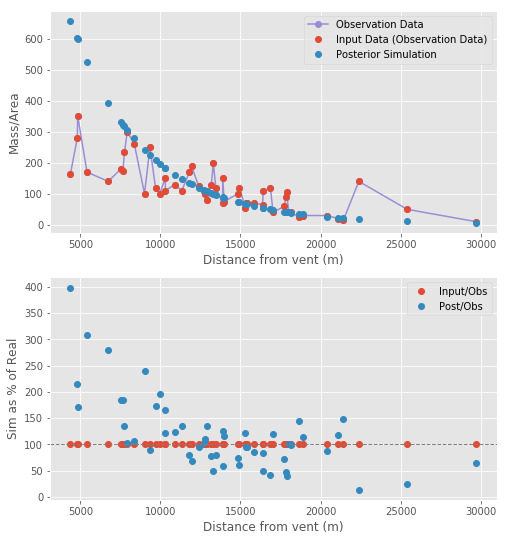

In [21]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values
    
    fig, axs = plt.subplots(4,1, figsize=(
            10, 20), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    bounds = (25, 350)
    vis.plot_sample(in_data, vent=(0,0), log=False,bounds=bounds, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, bounds=bounds,
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_residuals(post_df, vent=(0,0), values="Change", plot_type="cmap",
                title="Change from Input Dataset", cbar_label="log(Residual) (% of Input Mass)", ax=axs[2])
    vis.plot_residuals(post_df, vent=(0,0), values="Residual", plot_type="cmap",
                title="Residual with respect to Obs.", cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values*100, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   

In [15]:
# fig, axs = plt.subplots(2,1, figsize=(
#         8, 9), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# axs[0].plot(obs_df["radius"].values, rotdf["MassArea"].values, 'C0-', label="Obs")
# axs[0].plot(df_merge["radius"].values, df_merge["MassArea"].values, 'C1-', label="Prior")
# axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C2-', label="Post")
# axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3-', label="T2")
# axs[0].legend()
# axs[0].set_xlabel("Distance from vent (m)")
# axs[0].set_ylabel("Mass/Area")


# axs[1].plot(prior_res_obs["radius"].values, prior_res_obs["MassArea"].values, 'C1-', label="Prior/Obs")
# axs[1].plot(post_res_obs["radius"].values, post_res_obs["MassArea"].values, 'C2-', label="Post/Obs")
# axs[1].plot(t2_res_df["radius"].values, t2_res_df["MassArea"].values, 'C3-', label="T2/Obs")
# axs[1].legend()
# axs[1].set_xlabel("Distance from vent (m)")
# axs[1].set_ylabel("Residual (%)")
# plt.show()

========Forward Simulation========
a* = -0.42255	b* = -0.82600	            h1* = 0.74724	u* = -4.79618	v* = -57.57894	            D* = 11.65223	ftt* = 8.11316	TM* = 26.24473
a = 1.65537	b = 1.43780	            h1 = 28022.03042	u = 0.00826	v = 0.00000	            D = 114947.18976	ftt = 3338.11760	TM = 249999999999.99973
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 886
SSE: 1.754159263330593


,Height,Suspended Mass
0,"4,625",1.09123e+10
1,"6,750",1.64853e+10
2,"8,875",2.05349e+10
3,"11,000",2.35508e+10
4,"13,125",2.57137e+10
5,"15,250",2.70891e+10
6,"17,375",2.76739e+10
7,"19,500",2.73998e+10
8,"21,625",2.61058e+10
9,"23,750",2.34401e+10


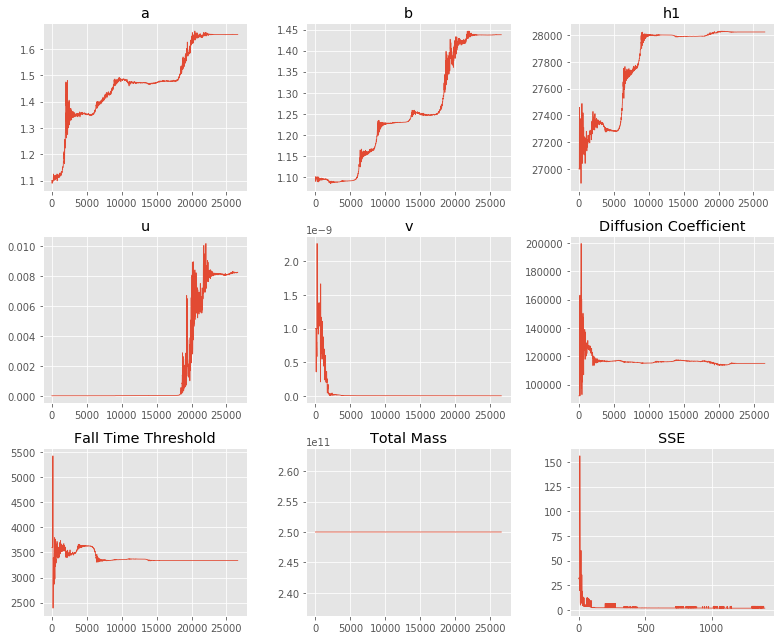

Forward Simulation Run Time: 6.56198 minutes


========T2 Simulation========
a* = -0.80918	b* = -2.70885	            h1* = 0.97907	u* = -9.14608	v* = -59.64006	            D* = 11.56943	ftt* = 8.36558	TM* = 26.24473
a = 1.44522	b = 1.06661	            h1 = 30907.59663	u = 0.00011	v = 0.00000	            D = 105812.71903	ftt = 4296.60873	TM = 249999999999.99973
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 907
SSE: 93.26154060455981


,Height,Suspended Mass
0,"4,625",9.15037e+09
1,"6,750",1.23887e+10
2,"8,875",1.4749e+10
3,"11,000",1.66515e+10
4,"13,125",1.8253e+10
5,"15,250",1.96294e+10
6,"17,375",2.08206e+10
7,"19,500",2.18459e+10
8,"21,625",2.27081e+10
9,"23,750",2.33901e+10


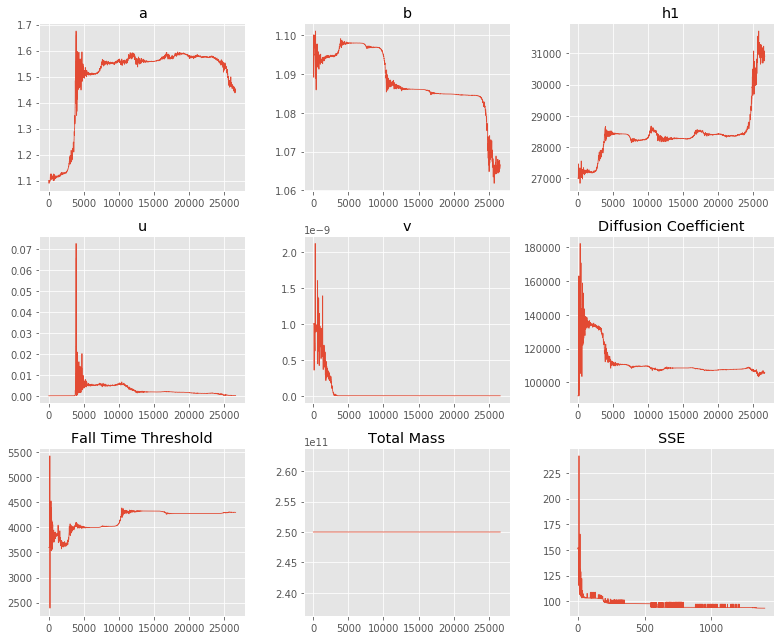

T2 Simulation Run Time: 6.03828 minutes


========Observation Data========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:430: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass
C:\Users\nmostert\Documents\repos\inversion_project\utils.py:461: RuntimeWarning: divide by zero encountered in double_scalars
  sse = (np.linalg.norm(fit - m)**2)/np.linalg.norm(fit)


a* = -2.06308	b* = -2.06308	            h1* = -0.64034	u* = -2.02090	v* = -115.43148	            D* = 12.43219	ftt* = 6.49568	TM* = 26.24473
a = 1.12706	b = 1.12706	            h1 = 6749.99995	u = 0.13254	v = 0.00000	            D = 250744.37605	ftt = 662.27164	TM = 249999999999.99973
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 870
SSE: 92118363332.66269


,Height,Suspended Mass
0,"4,625",2.5e+11
1,"6,750",0
2,"8,875",0
3,"11,000",0
4,"13,125",0
5,"15,250",0
6,"17,375",0
7,"19,500",0
8,"21,625",0
9,"23,750",0


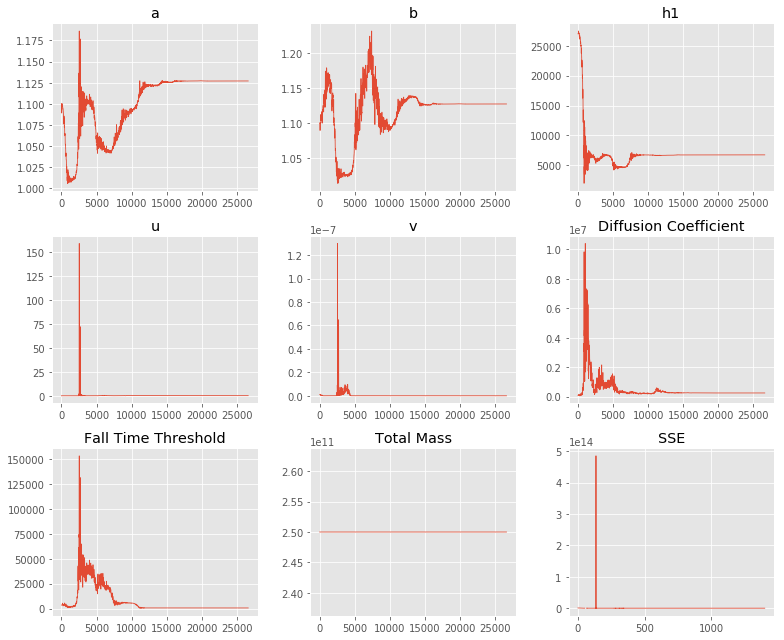

Observation Data Run Time: 6.07500 minutes


Total Run Time: 18.67526 minutes


In [16]:
priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": config["PLUME_HEIGHT"],
    "u": 1e-9,
    "v": 1e-9,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True,
    "D": True,
    "ftt": True,
    "M": False
}

H = 45000

t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

names = ["Forward Simulation", 
         "T2 Simulation",
         "Observation Data"]
data_sets = [forward_df, t2_df, obs_df]

inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    t = process_time()
    
    print("========%s========"%name)
    out = gaussian_stack_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], 
        H, 2500, phi_steps,
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    params_no_wind = list(params.values())
    params_no_wind = params_no_wind[:-5]
    
    inv_mass, _, _, _ = beta_transform(*plume_inv_transform(*params_no_wind, H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(name, run_time/60))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

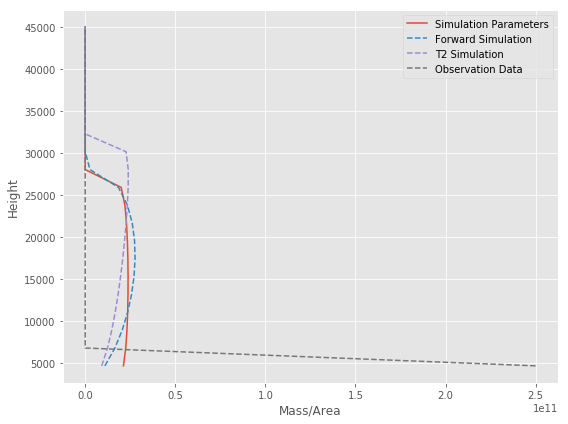

,Dataset,a,b,h1,u,v,D,ftt,M
0,Forward Simulation,1.65537,1.4378,"28,022",0.00826128,9.85793e-26,"114,947","3,338.12",2.5e+11
1,T2 Simulation,1.44522,1.06661,"30,907.6",0.000106637,1.25502e-26,"105,813","4,296.61",2.5e+11
2,Observation Data,1.12706,1.12706,"6,750",0.132536,7.39169e-51,"250,744",662.272,2.5e+11


In [17]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["Dataset"] = names
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

========Forward Simulation========


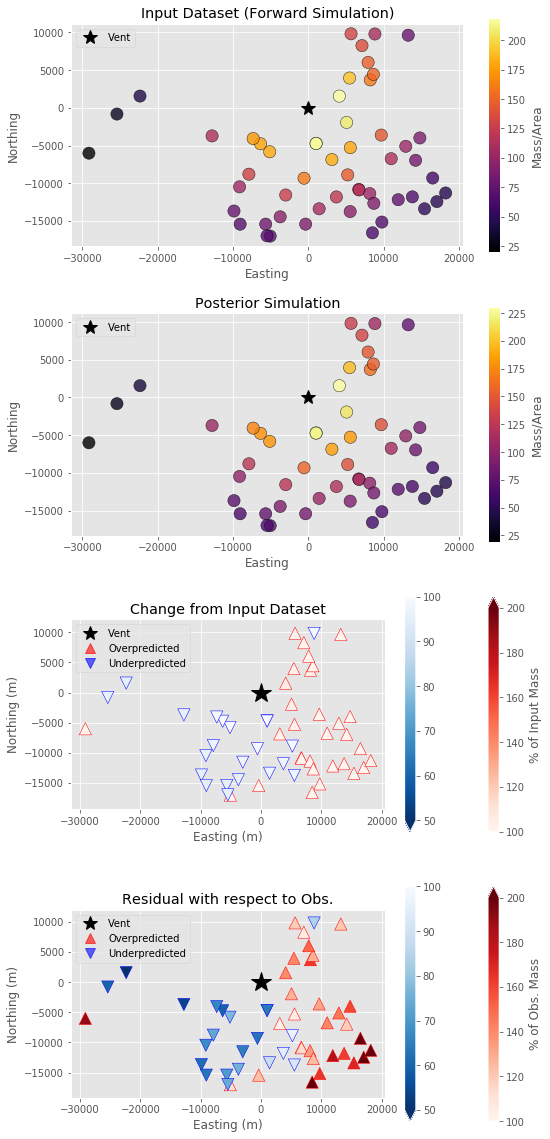

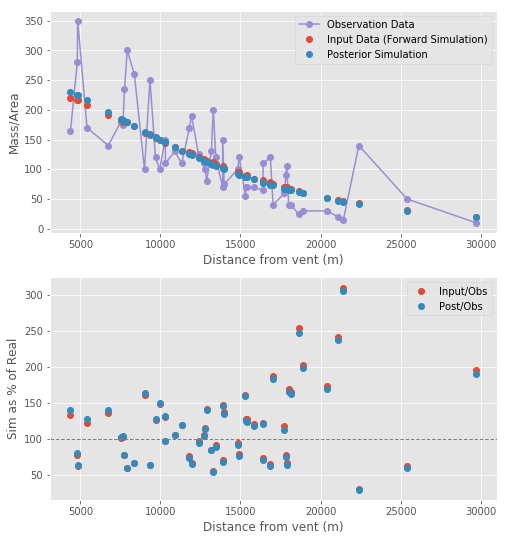

========T2 Simulation========


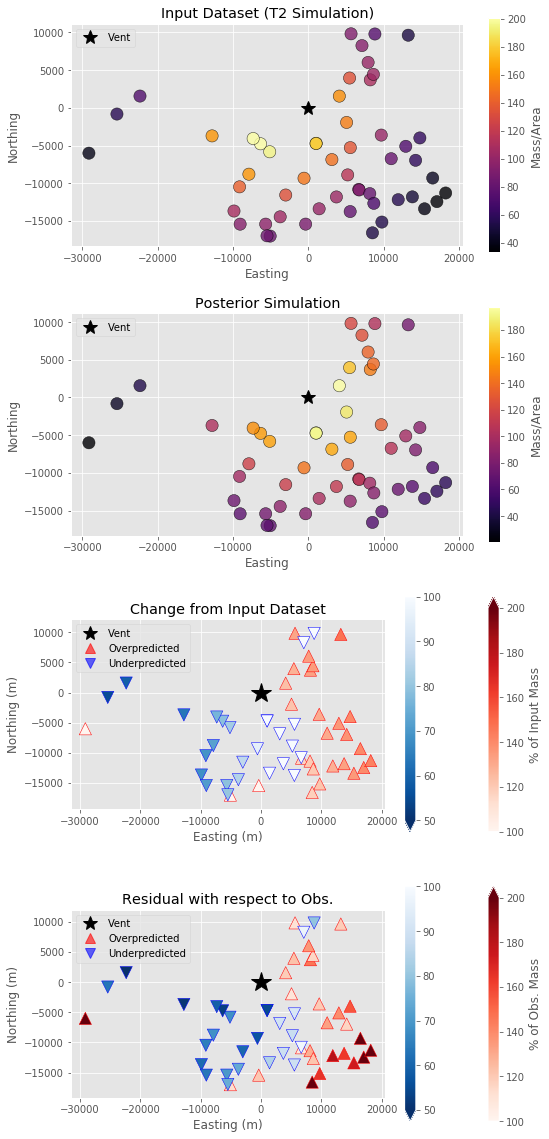

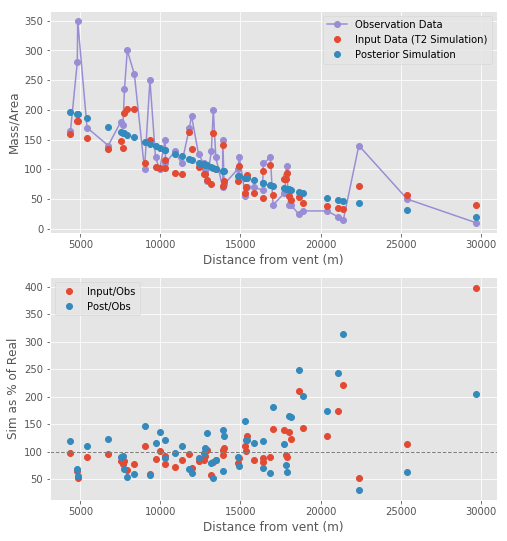

========Observation Data========


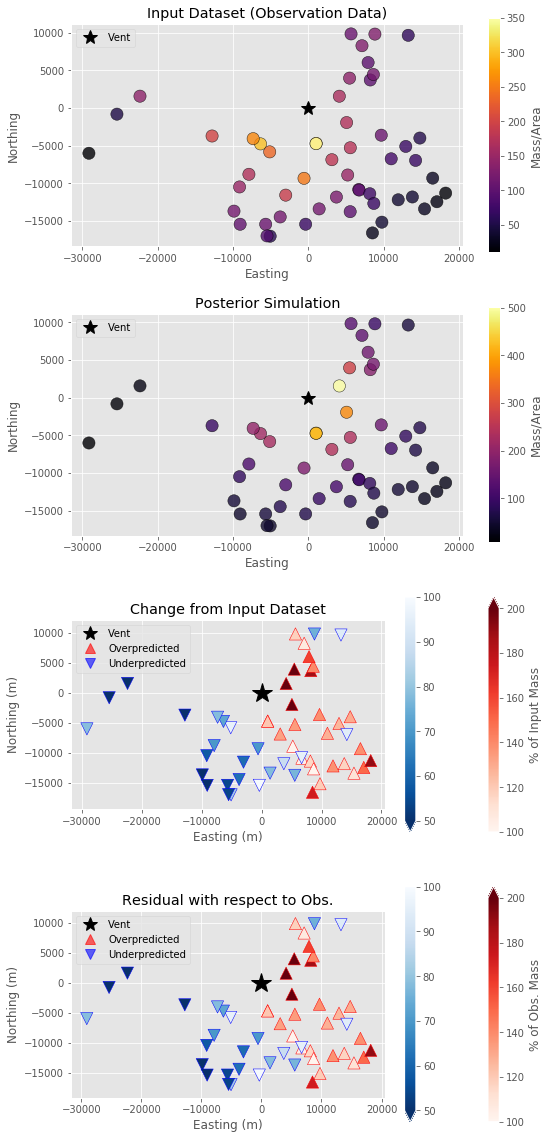

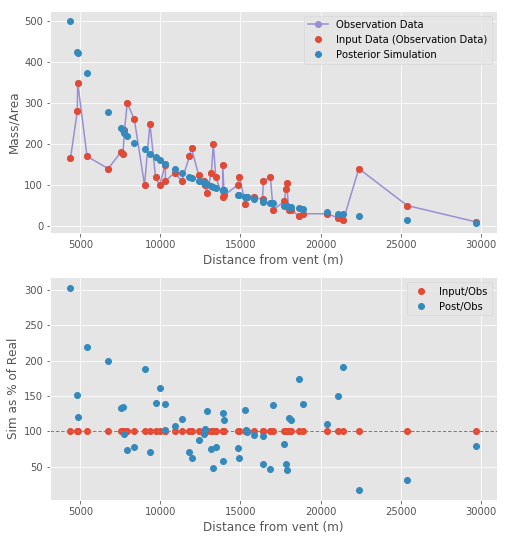

In [20]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (params["u"],params["v"]), params["D"], config["EDDY_CONST"],
        params["ftt"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values
    
    fig, axs = plt.subplots(4,1, figsize=(
            8, 16), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_residuals(post_df, vent=(0,0), values="Change", plot_type="cmap",
                title="Change from Input Dataset", cbar_label="% of Input Mass", ax=axs[2])
    vis.plot_residuals(post_df, vent=(0,0), values="Residual", plot_type="cmap",
                title="Residual with respect to Obs.", cbar_label="% of Obs. Mass", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values*100, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   

In [ ]:


a = [1,2,3,4,5,6]

b, c, d, \
    e, f, g = a

print(b, c, d, e, f, g)